In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [192]:
df = pd.read_csv('../data/nba.csv')

df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Travis Knight,LAL,22.0,213.36,106.59412,Connecticut,USA,1996,1,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1996-97
1,1,Matt Fish,MIA,27.0,210.82,106.59412,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,208.28,106.59412,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,3,Marty Conlon,BOS,29.0,210.82,111.13004,Providence,USA,Undrafted,Undrafted,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,4,Martin Muursepp,DAL,22.0,205.74,106.59412,None,USA,1996,1,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


In [193]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [177]:
df.season

0        1996-97
1        1996-97
2        1996-97
3        1996-97
4        1996-97
          ...   
11695    2020-21
11696    2020-21
11697    2020-21
11698    2020-21
11699    2020-21
Name: season, Length: 11700, dtype: object

# EDA

In [11]:
def show_top_n_by_stat_and_season(n, stat, season):
    players = df[df.season == season]
    players = players.sort_values(stat, ascending=False)
    players = players[:n]
    plot = sns.barplot(x=stat, y='player_name', data=players, order=players.sort_values(stat).player_name, palette='Pastel1')
    plot.set(ylabel='Players', xticks=range(0, int(np.max(players[stat])), 2))
    plt.show()

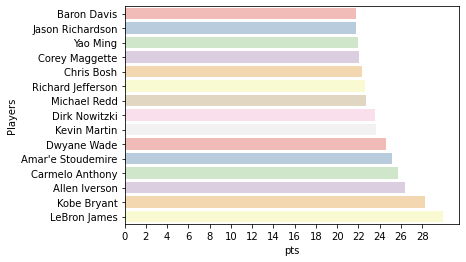

In [98]:
show_top_n_by_stat_and_season(15, 'pts', '2007-08')

In [36]:
def plot_team_season_stat(team_abbv, season):
    team = df[df.season == season]
    team = team[team['team_abbreviation'] == team_abbv]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x='pts', y='player_name', data=team, order=team.sort_values('pts').player_name, color='indianred',
                      label='Points')
    ax = sns.barplot(x='ast', y='player_name', data=team, order=team.sort_values('pts').player_name, color='dimgrey',
                      label='Assists')
    ax.set(ylabel='Players', xticks=range(0, int(np.max(team.pts)), 2), xlim=(0, 30))
    ax.legend(frameon=False)
    plt.show()

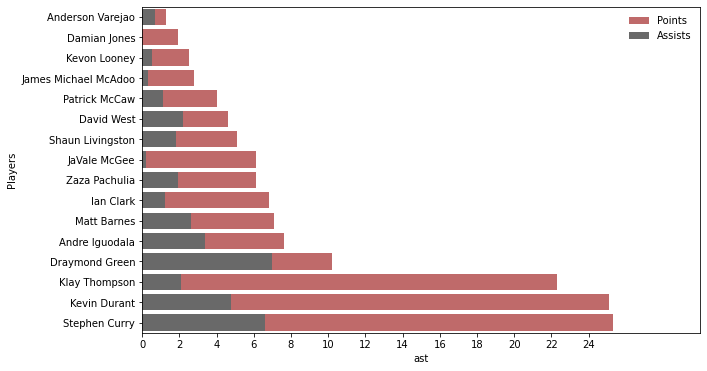

In [37]:
plot_team_season_stat('GSW', '2016-17')

In [96]:
def show_team_stat_through_years(team):
    fig, (ax, ax1, ax2) = plt.subplots(figsize=(10, 12), nrows=3, ncols=1, sharex=True)
    
    scatter = ax.scatter(df.age[df.team_abbreviation == team],
                        df.pts[df.team_abbreviation == team],
                        c='indianred')
    ax.set(ylabel='Points Per Game', title='PPG')
    ax.axhline(df.pts.mean(), linestyle='--', color='dimgrey')
    
    scatter = ax1.scatter(df.age[df.team_abbreviation == team],
                         df.reb[df.team_abbreviation == team],
                         c='skyblue')
    ax1.set(ylabel='Rebounds Per Game', title='RPG')
    ax1.axhline(df.reb.mean(), linestyle='--', color='darkorange')
    
    scatter = ax2.scatter(df.age[df.team_abbreviation == team],
                         df.ast[df.team_abbreviation == team],
                         c='darkgreen')
    ax2.set(ylabel='Assists Per Game', title='APG')
    ax2.axhline(df.ast.mean(), linestyle='--', color='firebrick')
    
    plt.suptitle(f'{team} stats through from 1996-97 to 2020-21')

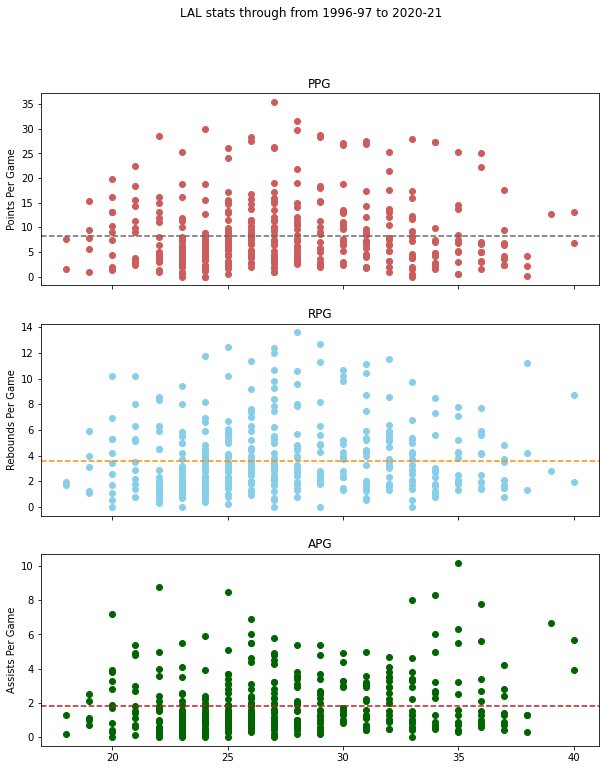

In [97]:
show_team_stat_through_years('LAL')

# Preprocess data

In [178]:
def preprocess_data(df):
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [179]:
df_tmp = preprocess_data(df)
df_tmp.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,2170,15,22.0,213.36,106.59412,62,73,21,2,29,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1
1,1545,17,27.0,210.82,106.59412,190,73,17,3,53,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1
2,1542,12,30.0,208.28,106.59412,115,73,46,9,76,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1
3,1532,3,29.0,210.82,111.13004,221,73,46,9,76,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1
4,1531,8,22.0,205.74,106.59412,185,73,21,2,25,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1


# Splitting data

In [194]:
df_1996_2010 = df[df.season < '2010-11']
df_train = preprocess_data(df_1996_2010)

In [195]:
df_2010_2020 = df['2010-11'<= df.season]
df_2010_2020 = df_2010_2020[df_2010_2020.season <= '2019-2020']
df_valid = preprocess_data(df_2010_2020)

In [196]:
df_2020_2021 = df[df.season == '2020-21']
df_test = preprocess_data(df_2020_2021)

In [197]:
X_train, y_train = df_train.drop('pts', axis=1), df_train['pts']
X_valid, y_valid = df_valid.drop('pts', axis=1), df_valid['pts']
X_test, y_test = df_test.drop('pts', axis=1), df_test['pts']

In [186]:
def split_data(df, stat):
    df.drop('Unnamed: 0', axis=1)
    df_1996_2010 = df[df.season < '2010-11']
    df_train = preprocess_data(df_1996_2010)
    df_2010_2020 = df['2010-11'<= df.season]
    df_2010_2020 = df_2010_2020[df_2010_2020.season <= '2019-2020']
    df_valid = preprocess_data(df_2010_2020)
    df_2020_2021 = df[df.season == '2020-21']
    df_test = preprocess_data(df_2020_2021)
    X_train, y_train = df_train.drop(stat, axis=1), df_train[stat]
    X_valid, y_valid = df_valid.drop(stat, axis=1), df_valid[stat]
    X_test, y_test = df_test.drop(stat, axis=1), df_test[stat]
    data = {
        'X_train':X_train,
        'y_train':y_train,
        'X_valid':X_valid,
        'y_valid':y_valid,
        'X_test':X_test,
        'y_test':y_test
    }
    return data

# Evaluation function

In [201]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [205]:
models = {
    'RandomForestRegressor':RandomForestRegressor(),
    'SVR':SVR(),
    'Ridge':Ridge()
}

results = {}

for name, model in models.items():
    model.fit(df_tmp.drop('pts', axis=1), df_tmp['pts'])
    results[name] = model.score(df_tmp.drop('pts', axis=1), df_tmp['pts'])

results

{'RandomForestRegressor': 0.9955231259866079,
 'SVR': 0.18270313516773884,
 'Ridge': 0.8755873936146371}

In [202]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {
        'Training MAE':mean_absolute_error(y_train, train_preds),
        'Valid MAE':mean_absolute_error(y_valid, valid_preds),
        'Training RMSE':rmse(y_train, train_preds),
        'Valid RMSE':rmse(y_valid, valid_preds),
        'Training R2':r2_score(y_train, train_preds),
        'Valid R2':r2_score(y_valid, valid_preds)
    }
    
    return scores

In [203]:
show_scores(model)

{'Training MAE': 0.28678991326694525,
 'Valid MAE': 0.9297938792055126,
 'Training RMSE': 0.41754948501724026,
 'Valid RMSE': 1.3684158543164238,
 'Training R2': 0.9951441853484783,
 'Valid R2': 0.9451105007647616}

# Hyperparameter tuning

In [206]:
rf_grid = {
    'n_estimators':np.arange(100, 1000, 100),
    'max_depth':[None, 3, 5],
    'max_features':['auto', 'sqrt', 'log2'],
    'min_samples_split':np.arange(2, 20, 2),
    'min_samples_leaf':np.arange(1, 20, 2)
}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                             param_distributions=rf_grid,
                             n_iter=20,
                             cv=5,
                             verbose=True,
                             random_state=23)

%time rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 11min 25s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=23, verbose=True)

In [207]:
rs_model.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [208]:
show_scores(rs_model)

{'Training MAE': 0.4075416938024865,
 'Valid MAE': 0.9509653126373319,
 'Training RMSE': 0.5978549279281609,
 'Valid RMSE': 1.4024203635441892,
 'Training R2': 0.9900450788810645,
 'Valid R2': 0.9423486485171841}

In [209]:
ideal_model = RandomForestRegressor(n_estimators=400,
                                   min_samples_leaf=1,
                                   min_samples_split=10,
                                   max_depth=None,
                                   max_features='auto')
ideal_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=400)

In [224]:
show_scores(ideal_model)

{'Training MAE': 0.4060845307229065,
 'Valid MAE': 0.9490718892924328,
 'Training RMSE': 0.5958486677857189,
 'Valid RMSE': 1.3965880818582186,
 'Training R2': 0.9901117795122671,
 'Valid R2': 0.9428271637575725}

# Making predictions on test data

In [212]:
test_preds = ideal_model.predict(X_test)

In [215]:
test_preds[:10]

array([ 5.87468037, 23.28047981,  2.2942005 , 25.69450173,  4.75588754,
        7.26093878,  5.90750453,  9.9217933 ,  7.56722979,  2.87079822])

In [220]:
df = pd.read_csv('../data/nba.csv')
df_2020_2021 = df[df.season == '2020-21']

df_preds = pd.DataFrame()
df_preds['player_name'] = df_2020_2021['player_name']
df_preds['points'] = test_preds
df_preds.head(30)

,player_name,points
11160,Yogi Ferrell,5.874680
11161,Zion Williamson,23.280480
11162,Zeke Nnaji,2.294201
11163,Zach LaVine,25.694502
11164,Yuta Watanabe,4.755888
11165,Xavier Tillman,7.260939
11166,Willie Cauley-Stein,5.907505
11167,Frank Kaminsky,9.921793
11168,Frank Mason,7.567230
11169,Frank Ntilikina,2.870798


In [221]:
df_preds.to_csv('../data/2020-21-PPG-Prediction.csv')

# Feature importance

In [222]:
def plot_feature_importance(col, importance, n=20):
    df = pd.DataFrame({'features':col,
                 'feature_importance':importance}).sort_values('feature_importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df['features'][:20], df['feature_importance'][:20], color='hotpink')
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importances')

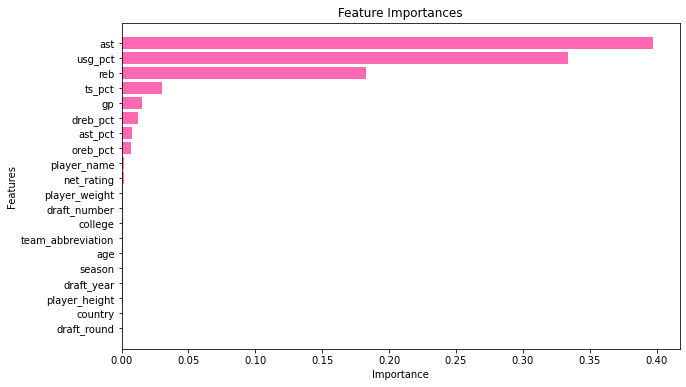

In [223]:
plot_feature_importance(X_train.columns, ideal_model.feature_importances_)